<a href="https://colab.research.google.com/github/GusevMihail/seamless_textute_generator/blob/master/sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


In [5]:
import os.path
import sys
if 'google' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir data
    !mkdir data/train
    if os.path.exists('data/train'):
        !cp /content/drive/MyDrive/Colab/seamless_textute_generator/data/concrete_maps_1K.zip data
        !unzip -q -n data/concrete_maps_1K.zip -d data/train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/train’: File exists


In [6]:
from typing import Tuple, Any
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import cv2

import albumentations as albu
from albumentations.pytorch import ToTensorV2

# Dataset

In [7]:
data_folder = r'data/train'
image_names = tuple(f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f)))
train_val, test_names = train_test_split(image_names, train_size = 0.8)
train_names, val_names = train_test_split(train_val, train_size = 0.75)

In [76]:
from torch.utils import data

class TextureDataset(data.Dataset):

    def __init__(self, root_path: str, file_list: list, transforms: Any=None, 
                 cross_koeff: float=0.1, im_size: Tuple[int, int]=(224, 224)):
        super().__init__()
        self.root_path = root_path
        self.file_list = file_list
        self.transforms = transforms
        self.im_size = im_size
        self.cross_coeff = cross_koeff

    def __len__(self):
        return len(self.file_list)*3

    def __getitem__(self, index: int) -> Tuple[np.array, np.array]:
        if index >= len(self.file_list):
            return self.__getitem__(np.random.randint(0, len(self.file_list)))

        image_path = os.path.join(self.root_path, self.file_list[index])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            transformed = self.transforms(image=image)
            image = transformed['image']
            # mask = transformed['mask']

        X, mask = self.cut_cross(image)
        return X, mask, image

        # return image, image, image

    def cut_cross(self, img: np.array)->Tuple[np.array, np.array]:
        _, height, width= img.shape
        # Размеры креста
        cross_height = round(height * self.cross_coeff / 2)
        cross_width = round(width * self.cross_coeff / 2)

        # Индексы вырезания креста
        start_height_idx = round(height / 2 - cross_height)
        end_height_idx = round(height / 2 + cross_height)

        start_width_idx = round(width / 2 - cross_width)
        end_width_idx = round(width / 2 + cross_width)

        # Вырежем крест
        X = deepcopy(img)
        X[:, start_height_idx : end_height_idx] = 0
        X[..., start_width_idx : end_width_idx] = 0
        # Определим маску креста
        mask = torch.zeros(X.shape[1:])
        mask[start_height_idx : end_height_idx] = 1.
        mask[:, start_width_idx : end_width_idx] = 1.
        return X, mask

In [77]:
resize_transform = albu.Compose([albu.SmallestMaxSize(224),
                                 albu.RandomCrop(224, 224),
                                #  albu.Resize(224, 224),
                                 albu.Normalize(),
                                 ToTensorV2()])

In [78]:
train_data = TextureDataset(data_folder, train_names, resize_transform)
val_data = TextureDataset(data_folder, val_names, resize_transform)
test_data = TextureDataset(data_folder, test_names, resize_transform)

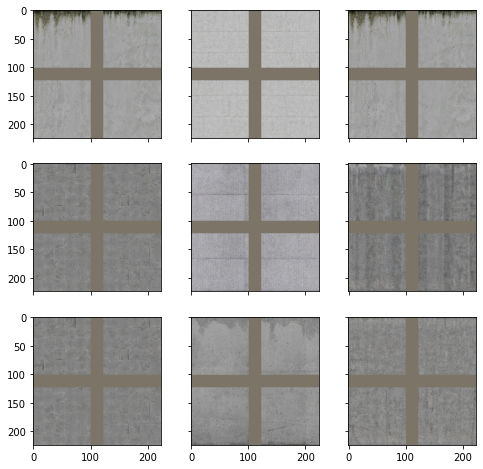

In [69]:
# look at the image
np.random.seed(42)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)

for fig_x in ax.flatten():
    i = np.random.choice(len(train_data), 1)[0]
    im , _, _ = train_data[i]
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
        )
    im = inv_normalize(im)
    fig_x.imshow(np.moveaxis(im.numpy(), 0, -1))
    fig_x.grid(False)

In [79]:
train_loader = DataLoader(train_data, batch_size=30, )
val_loader = DataLoader(val_data, batch_size=5)
test_loader = DataLoader(test_data, batch_size=5)

## Model

In [80]:
class FullyConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self._model = nn.Sequential(
             nn.Conv2d(in_channels, 16, 3, 2, self.same_padding(3)),   # 224
             nn.ReLU(),
             nn.BatchNorm2d(16),
             nn.Conv2d(16, 32, 3, 2, self.same_padding(3)),            # 112
             nn.ReLU(),
             nn.BatchNorm2d(32),
             nn.Conv2d(32, 64, 3, 2, self.same_padding(3)),            # 56
             nn.ReLU(),
             nn.BatchNorm2d(64),
             nn.Conv2d(64, 128, 3, 2, self.same_padding(3)),           # 28
             nn.ReLU(),
             nn.BatchNorm2d(128),
             nn.Conv2d(128, 256, 3, 2, self.same_padding(3)),          # 14
             nn.ReLU(),
             nn.AdaptiveAvgPool2d(1),                                  # 7
             nn.Conv2d(256, 512, 1, 1, self.same_padding(1)),          # 1
             nn.ReLU(),
             nn.Dropout(0.2),
             nn.Conv2d(512, out_channels, 1, 1, self.same_padding(1))) # 1 
        
    @staticmethod
    def same_padding(kernel_size):
        return (kernel_size - 1) // 2
    
    def forward(self, X):
        return self._model(X)

In [81]:
# from copy import deepcopy
from tqdm import tqdm

def do_epoch(model, optimizer, loss_func, data_loader,
             mode='T', metric=None, title=None):
    """
    Compute one epoch
    :param model: (nn.Module) model
    :param optimizer: (torch.optim) optimization method. Ignored if mode='V'
    :param loss_func: (func) loss functions
    :param data_loader: (MyDataLoader) val batches generator (X, y). Default None
    :param mode: (str) 'T' - Train or 'V' - Validate. Default 'T'
    :param metric: (func) target metric
    :param title: (str) description in progress bar
    :return:
        epoch_loss: mean loss
        epoch_metric: mean metric
    """
    if mode not in ['V', 'T']:
        raise ValueError('mode should be "T" or "V"')
    # History
    epoch_loss = 0.
    epoch_metric = 0.


    with tqdm(total=len(data_loader)) as progress_bar:
        for ind, (X, mask, y) in enumerate(data_loader, 1):
            description = ''
            if title is not None:
                description += title
            description += f'Mode: {mode} |'
            # X_tens, y_tens = torch.as_tensor(X, dtype=torch.float, device=DEVICE), \
            #                  torch.as_tensor(y, dtype=torch.long, device=DEVICE)
            X_tens = X.to(DEVICE)
            y_tens = y.to(DEVICE)
            mask_tens = mask.to(DEVICE).unsqueeze(1)
            y_shape = tuple(y.size())
            predict = model(X_tens).view(*y_shape)
            loss = loss_func(predict * mask_tens, y_tens * mask_tens)
            epoch_loss += loss.item()
            description += f'Loss: {epoch_loss / ind: 7.4} |'

            # backward
            if mode == 'T':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            #  metric calculate
            if metric is not None:
                epoch_metric += metric(predict, y_tens)
                description += f'Metric: {epoch_metric / ind: 7.4} |'

            progress_bar.set_description(description)
            progress_bar.update()
    return epoch_loss / len(data_loader), epoch_metric / len(data_loader)


def train(model, train_loader, loss_func, optimizer, epoch_count=10,
          metric=None, val_loader=None, scheduler=None):
    """
    Training model
    :param model: (torch.nn.Module) model for train
    :param train_loader: (MyDataLoader) train batches generator (X, y)
    :param loss_func: (func) loss functions
    :param optimizer: (torch.optim) optimization method
    :param epoch_count: (int) epochs count. Default 10
    :param metric: (func) target metric
    :param val_loader: (MyDataLoader) val batches generator (X, y). Default None
    :param scheduler: (torch.utils)
    :return:
        history_info: dict of training history consist "Tloss", "Tmetric",
                    "Vloss", "Vmetric"
        best_model_param: model parameters at the highest Vmetric value
    """
    # Train_history
    history_info = {'Tloss': [], 'Tmetric': [],
                    'Vloss': [], 'Vmetric': []}
    # best Val_score and model params
    best_score = 0.
    best_model_param = {}

    datasets = {}

    if train_loader is not None:
        datasets.update({'T': train_loader})
    if val_loader is not None:
        datasets.update({'V': val_loader})

    for epoch in range(epoch_count):
        for mode, data in datasets.items():
            # title for progress bar
            title = f'[{epoch+1: 3}/{epoch_count}]|'
            model.train(mode == 'T')
            epoch_loss, epoch_metric = \
                do_epoch(model, optimizer, loss_func, data,
                         mode, metric, title)
            history_info[mode + 'loss'].append(epoch_loss)
            history_info[mode + 'metric'].append(epoch_metric)

            if metric is not None:
                # save best metric value and model parameters
                if best_score < epoch_metric and mode == 'V':
                    best_score = epoch_metric
                    best_model_param = deepcopy(model.state_dict())

            # scheduler step
            if scheduler is not None and mode == 'V':
                scheduler.step(epoch_metric)

    return history_info, best_model_param


def accuracy(predict_proba, ground_truth):
    """
    Compute accuracy
    :param predict_proba: (torch.Tensor) prediction probability 2D dim
    :param ground_truth: (torch.Tensor) ground truth labels
    :return: (float) accuracy
    """
    label_index = torch.argmax(predict_proba, dim=-1)
    true_predict = (label_index == ground_truth).sum().item()
    return true_predict / ground_truth.size()[0]

In [82]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred[:, [1]] - y_real * y_pred[:, [1]] + torch.log(1 + torch.exp(-y_pred[:, [1]])))

## Train

In [100]:
model = FullyConv(3, 224*224*3)
model = model.to(DEVICE)

In [110]:
lr = 1e-4

# loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

[  1/5]|Mode: T |Loss:  0.02886 |: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]
[  1/5]|Mode: V |Loss:  0.06595 |: 100%|██████████| 6/6 [00:00<00:00, 11.69it/s]
[  2/5]|Mode: T |Loss:  0.03102 |: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]
[  2/5]|Mode: V |Loss:  0.04968 |: 100%|██████████| 6/6 [00:00<00:00, 11.99it/s]
[  3/5]|Mode: T |Loss:  0.02992 |: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]
[  3/5]|Mode: V |Loss:  0.06033 |: 100%|██████████| 6/6 [00:00<00:00, 11.35it/s]
[  4/5]|Mode: T |Loss:  0.0278 |: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]
[  4/5]|Mode: V |Loss:  0.05625 |: 100%|██████████| 6/6 [00:00<00:00, 12.13it/s]
[  5/5]|Mode: T |Loss:  0.02826 |: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]
[  5/5]|Mode: V |Loss:  0.05857 |: 100%|██████████| 6/6 [00:00<00:00, 10.96it/s]


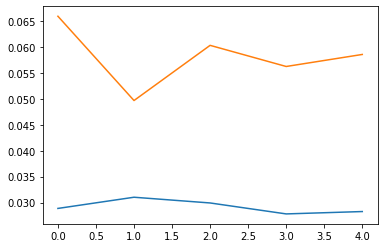

In [111]:
train_hist, _ = train(model, train_loader, loss_fn, optim, 5, val_loader=val_loader)
plt.plot(train_hist['Tloss'])
plt.plot(train_hist['Vloss']);

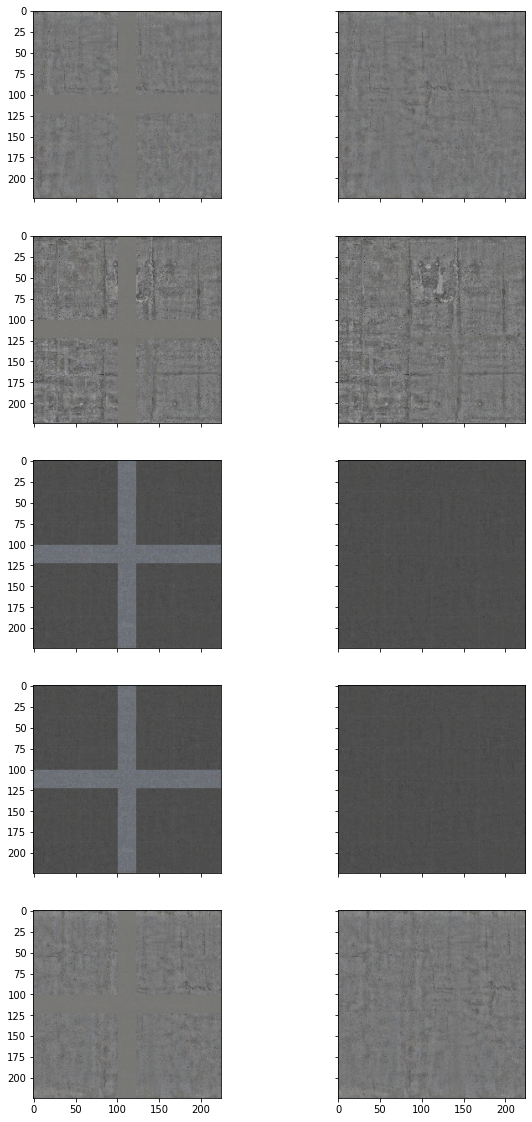

In [112]:
np.random.seed(42)
samples = 5
fig, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 20),
                       sharey=True, sharex=True)
# Денормализация
inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
        )

model.train(False)

for col_idx in range(samples):
    i = np.random.choice(len(test_data), 1)[0]
    X , mask, y = test_data[i]
    y = inv_normalize(y)
    X_tens = torch.as_tensor(X, dtype=torch.float, device=DEVICE)

    pred = model(X_tens.unsqueeze(0))
    pred = inv_normalize(pred.view(1, 3, 224, 224))
    pred = pred.detach().cpu().numpy().reshape(3, 224, 224)
    y_pred = y.numpy() * (~mask.numpy().astype(bool)) + pred * mask.numpy()
    
    ax[col_idx, 0].imshow(np.moveaxis(y_pred, 0, -1))
    ax[col_idx, 0].grid(False)

    ax[col_idx, 1].imshow(np.moveaxis(y.numpy(), 0, -1))
    ax[col_idx, 1].grid(False)